## Financial Analysis of Hydrogen Financing Using PyPSA-Earth

This notebook utilizes the PyPSA-Earth framework to analyze the financial aspects of hydrogen within a given network (.nc) file. The analysis includes detailed calculations and visualizations of:

- Hydrogen Capital Expenditures (CAPEX)
- Hydrogen Operational Expenditures (OPEX)
- Hydrogen Supply
- Hydrogen Revenue
- Levelized Cost of Hydrogen (LCOH)

By examining these financial metrics, insights into the economic feasibility and cost structure of hydrogen production in the modeled network are provided.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the hydrogen financing information.
* Configuration file (.yaml) with H2 Electrolysis color

### Import packages

In [59]:
import yaml
import pypsa
import matplotlib.pyplot as plt

### Path settings
This section reads the config parameters from your config.yaml file and automatically reads the output of the optimization with those settings

In [60]:
# Set your pypsa-earth directory here
PARENT = "/home/pypsa-earth/"
# Set your network path (.nc) here if applicable
network_path = PARENT + f"results/networks/elec_s_10_ec_lc3.0_Co2L_3H_2035_0.071_AB_14export.nc"
n = pypsa.Network(network_path)
statistics = n.statistics()
config_path = PARENT + f"/config.yaml"
config = yaml.safe_load(open(config_path))
hydrogen_color = config["plotting"]["tech_colors"]["h2 electrolysis"]

### Basic Ideas

In [61]:
def plot_metric_share(statistics, metric, total_metric, label, title, unit):
    """
    Plot the share of a specific metric (e.g., CAPEX, OPEX, Supply, Revenue) for hydrogen as a pie chart.
    
    Parameters:
        statistics (pd.DataFrame): DataFrame containing metric information.
        metric (str): Metric type (e.g., 'Capital Expenditure', 'Operational Expenditure', 'Supply', 'Revenue').
        total_metric (float): Total value of the metric for all components (e.g., in Mio. €, TWh).
        label (str): Label for hydrogen factor in the chart.
        title (str): Title for the pie chart.
        unit (str): Unit of the metric for display (e.g., 'Mio. €', 'TWh').
    """
    # Calculate hydrogen metric
    h2_metric = (statistics.loc["Link", "H2 Electrolysis"][metric] / 1e6).round(2)
    other_metric = (total_metric - h2_metric).round(2)

    # Print metric details
    print(f"H2 {label} is: {h2_metric} {unit}")
    print(f"Other {label} is: {other_metric} {unit}")
    print(f"Total {label} is: {total_metric} {unit}")

    # Prepare data for the pie chart
    values = [h2_metric, other_metric]
    labels = [f"H2 {label}", f"Other {label}"]
    colors = [hydrogen_color, "lightgrey"]

    # Plot the pie chart
    plt.figure(figsize=(6, 6))  # Set figure size
    plt.pie(values, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title(title)
    plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 0.8))
    plt.axis('equal')  # Ensures the pie chart is circular
    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()


In [62]:
h2_electrolysis = (
        statistics.loc["Link", "H2 Electrolysis"]
)
h2_electrolysis

Optimal Capacity           6.158121e+03
Installed Capacity         0.000000e+00
Supply                     1.643287e+07
Withdrawal                 2.347553e+07
Energy Balance            -7.042659e+06
Transmission               0.000000e+00
Capacity Factor            4.351741e-01
Curtailment                0.000000e+00
Capital Expenditure        2.104466e+08
Operational Expenditure    2.184250e+05
Revenue                    2.106629e+08
Market Value               1.281961e+01
Name: (Link, H2 Electrolysis), dtype: float64

H2 CAPEX is: 210.45 Mio. €
Other CAPEX is: 11.32 Mio. €
Total CAPEX is: 221.77 Mio. €


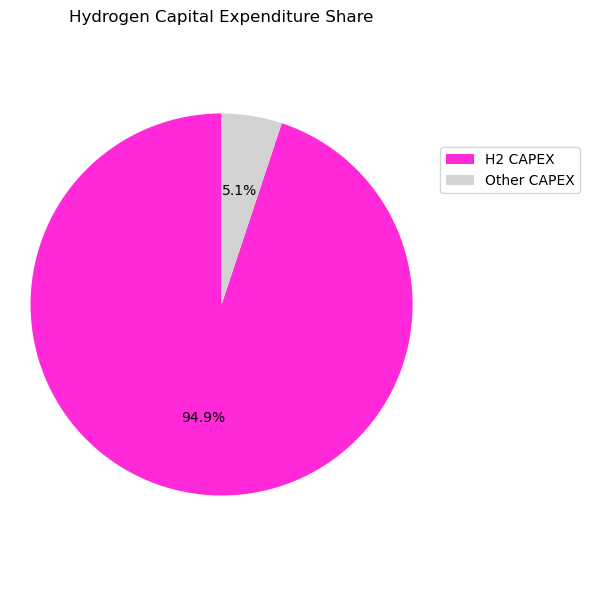

In [63]:
# CAPEX Example
total_capex = (n.statistics.capex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Capital Expenditure",
    total_metric=total_capex,
    label="CAPEX",
    title="Hydrogen Capital Expenditure Share",
    unit="Mio. €",
)

H2 OPEX is: 0.22 Mio. €
Other OPEX is: 4.92 Mio. €
Total OPEX is: 5.14 Mio. €


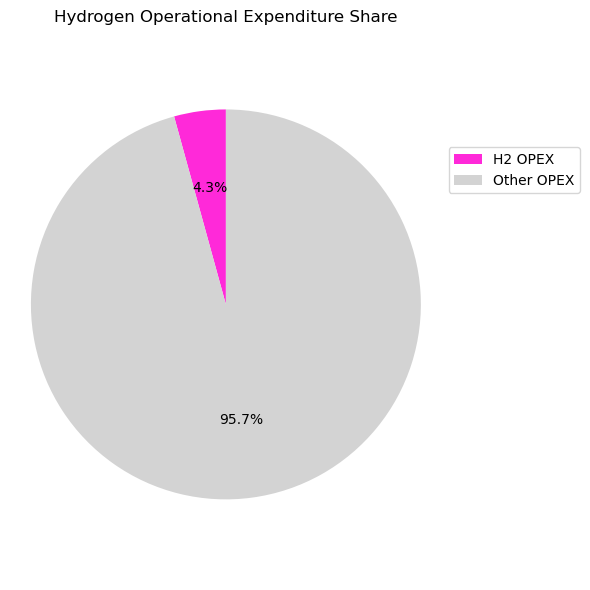

In [64]:
total_opex = (n.statistics.opex(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Operational Expenditure",
    total_metric=total_opex,
    label="OPEX",
    title="Hydrogen Operational Expenditure Share",
    unit="Mio. €",
)


H2 Supply is: 16.43 TWh
Other Supply is: 70.86 TWh
Total Supply is: 87.29 TWh


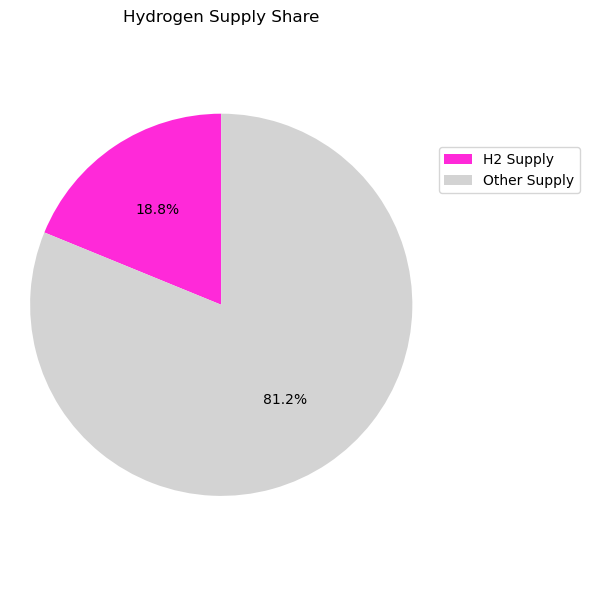

In [65]:
total_supply = (n.statistics.supply(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Supply",
    total_metric=total_supply,
    label="Supply",
    title="Hydrogen Supply Share",
    unit="TWh",
)

H2 Revenue is: 210.66 Mio. €
Other Revenue is: 16.72 Mio. €
Total Revenue is: 227.38 Mio. €


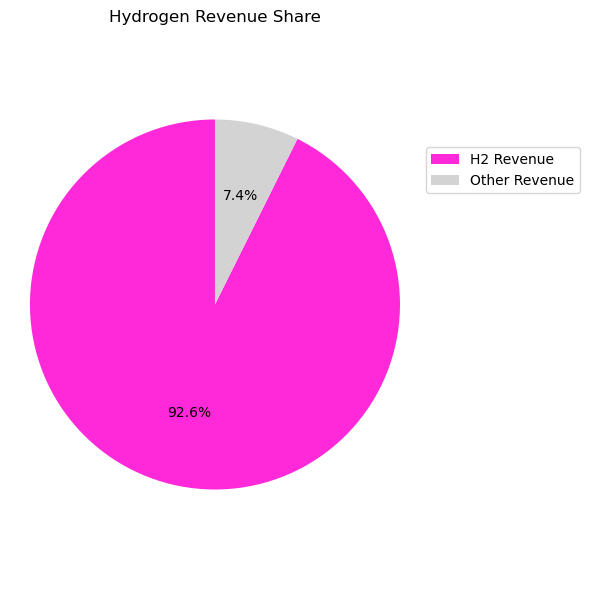

In [66]:
total_revenue = (n.statistics.revenue(comps=["Link"]).sum() / 1e6).round(2)
plot_metric_share(
    statistics=statistics,
    metric="Revenue",
    total_metric=total_revenue,
    label="Revenue",
    title="Hydrogen Revenue Share",
    unit="Mio. €",
)

In [67]:
h2_capex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Capital Expenditure"]
        .round(2)
        / 1e6
) 

h2_opex = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Operational Expenditure"]
        .round(2)
        / 1e6
) 

h2_supply = (
        statistics.loc["Link", "H2 Electrolysis"]
        .loc["Supply"]
        .round(2)
        / 1e6
) 

# Determine expense on electricity for hydrogen production
buses_sel = n.buses[n.buses.carrier == "AC"].index
prices = n.buses_t.marginal_price[buses_sel]
demand = n.links_t.p1[n.links[n.links.carrier == "H2 Electrolysis"].index]

demand.columns = (
    prices.columns
)  # Adjust column names to match prices for multiplication

e_cost = (
    (prices * demand).sum().sum()
    * (-1)
    * n.snapshot_weightings.generators[0]
    / 1e6
)  # in Mio. €

lcoh_compo = ((h2_opex + h2_opex + e_cost) / h2_supply).round(2)  # in €/MWh
print(f"Levelized Cost of Hydrogen (LCOH) is: {lcoh_compo} €/MWh")

Levelized Cost of Hydrogen (LCOH) is: 28.01 €/MWh
